In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
sc.pp.subsample(data_facs_ct, n_obs=20000, random_state=0, copy=False)
print('# Subsampled TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# Subsampled TMS facs count data: n_cell=20000, n_gene=22966
# time=19.1s


### Compute TRS

In [4]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [5]:
# Obtain TRS: This takes a lot of time.
from itertools import product

DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
simu_list = [x.replace('_rep1','') for x in os.listdir(DATA_PATH+'/data_null_geneset') if x[-5:]=='_rep1']
simu_list.sort()
n_rep=100

start_time = time.time()
dic_trs={}

md_list = [['mean_match', 'mean', 'empi'],
           ['mean_match', 'mean', 'recipe_vision'],
           ['mean_match', 'vst', 'empi'],
           ['mean_match', 'vst', 'recipe_vision']]

for simu in simu_list:
    for i_rep in np.arange(n_rep):
        
        trait = '%s_rep%d'%(simu,i_rep)
        temp_df = pd.read_csv(DATA_PATH+'/data_null_geneset/'+trait, sep='\t')
        
        print('# %-30s time=%0.1fs'%(trait,time.time()-start_time))
        
        for ctrl_opt,trs_opt,bc_opt in md_list:
            
            # Equal weight
            md.score_cell(data_facs_ct, temp_df['gene'].values, suffix='', 
                          ctrl_opt=ctrl_opt, trs_opt=trs_opt, bc_opt=bc_opt,
                          n_ctrl=1, n_genebin=200, 
                          return_list=['trs_ep'], verbose=False)
            term='%s_equal;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
            dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()

            # Uniform weight
            md.score_cell(data_facs_ct, temp_df['gene'].values, 
                          gene_weight=temp_df['gene_weight.unif'].values, suffix='', 
                          ctrl_opt=ctrl_opt, trs_opt=trs_opt, bc_opt=bc_opt,
                          n_ctrl=1, n_genebin=200, 
                          return_list=['trs_ep'], verbose=False)
            term='%s_unif;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
            dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()

            # Normal weight
            md.score_cell(data_facs_ct, temp_df['gene'].values, 
                          gene_weight=temp_df['gene_weight.normal'].values, suffix='', 
                          ctrl_opt=ctrl_opt, trs_opt=trs_opt, bc_opt=bc_opt,
                          n_ctrl=1, n_genebin=200, 
                          return_list=['trs_ep'], verbose=False)
            term='%s_norm;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
            dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()
        
            

# all_size100_rep0               time=0.0s
# all_size100_rep1               time=8.4s
# all_size100_rep2               time=16.5s
# all_size100_rep3               time=24.8s
# all_size100_rep4               time=33.2s
# all_size100_rep5               time=41.4s
# all_size100_rep6               time=49.5s
# all_size100_rep7               time=57.7s
# all_size100_rep8               time=65.9s
# all_size100_rep9               time=74.0s
# all_size100_rep10              time=82.2s
# all_size100_rep11              time=90.3s
# all_size100_rep12              time=98.5s
# all_size100_rep13              time=106.8s
# all_size100_rep14              time=115.0s
# all_size100_rep15              time=123.4s
# all_size100_rep16              time=131.6s
# all_size100_rep17              time=139.9s
# all_size100_rep18              time=148.1s
# all_size100_rep19              time=156.4s
# all_size100_rep20              time=164.7s
# all_size100_rep21              time=173.2s
# all_size100_rep22      

# all_size20_rep82               time=1382.7s
# all_size20_rep83               time=1389.5s
# all_size20_rep84               time=1396.5s
# all_size20_rep85               time=1403.3s
# all_size20_rep86               time=1410.2s
# all_size20_rep87               time=1417.1s
# all_size20_rep88               time=1424.1s
# all_size20_rep89               time=1431.0s
# all_size20_rep90               time=1437.7s
# all_size20_rep91               time=1444.7s
# all_size20_rep92               time=1451.7s
# all_size20_rep93               time=1458.6s
# all_size20_rep94               time=1465.5s
# all_size20_rep95               time=1472.5s
# all_size20_rep96               time=1479.5s
# all_size20_rep97               time=1486.5s
# all_size20_rep98               time=1493.3s
# all_size20_rep99               time=1500.2s
# all_size500_rep0               time=1507.0s
# all_size500_rep1               time=1518.5s
# all_size500_rep2               time=1529.9s
# all_size500_rep3               t

# highexp_size100_rep61          time=2642.3s
# highexp_size100_rep62          time=2646.8s
# highexp_size100_rep63          time=2651.2s
# highexp_size100_rep64          time=2655.7s
# highexp_size100_rep65          time=2660.2s
# highexp_size100_rep66          time=2664.6s
# highexp_size100_rep67          time=2669.0s
# highexp_size100_rep68          time=2673.4s
# highexp_size100_rep69          time=2677.8s
# highexp_size100_rep70          time=2682.2s
# highexp_size100_rep71          time=2686.6s
# highexp_size100_rep72          time=2690.9s
# highexp_size100_rep73          time=2695.4s
# highexp_size100_rep74          time=2699.8s
# highexp_size100_rep75          time=2704.2s
# highexp_size100_rep76          time=2708.6s
# highexp_size100_rep77          time=2713.1s
# highexp_size100_rep78          time=2717.5s
# highexp_size100_rep79          time=2721.9s
# highexp_size100_rep80          time=2726.3s
# highexp_size100_rep81          time=2730.7s
# highexp_size100_rep82          t

# highexp_size500_rep40          time=3374.8s
# highexp_size500_rep41          time=3379.8s
# highexp_size500_rep42          time=3384.6s
# highexp_size500_rep43          time=3389.6s
# highexp_size500_rep44          time=3394.5s
# highexp_size500_rep45          time=3399.6s
# highexp_size500_rep46          time=3404.4s
# highexp_size500_rep47          time=3409.3s
# highexp_size500_rep48          time=3414.2s
# highexp_size500_rep49          time=3419.1s
# highexp_size500_rep50          time=3424.1s
# highexp_size500_rep51          time=3429.1s
# highexp_size500_rep52          time=3433.9s
# highexp_size500_rep53          time=3438.9s
# highexp_size500_rep54          time=3443.8s
# highexp_size500_rep55          time=3448.6s
# highexp_size500_rep56          time=3453.7s
# highexp_size500_rep57          time=3458.5s
# highexp_size500_rep58          time=3463.5s
# highexp_size500_rep59          time=3468.5s
# highexp_size500_rep60          time=3473.4s
# highexp_size500_rep61          t

# lowexp_size20_rep19            time=4083.3s
# lowexp_size20_rep20            time=4086.6s
# lowexp_size20_rep21            time=4089.9s
# lowexp_size20_rep22            time=4093.2s
# lowexp_size20_rep23            time=4096.5s
# lowexp_size20_rep24            time=4099.9s
# lowexp_size20_rep25            time=4103.2s
# lowexp_size20_rep26            time=4106.5s
# lowexp_size20_rep27            time=4109.8s
# lowexp_size20_rep28            time=4113.1s
# lowexp_size20_rep29            time=4116.4s
# lowexp_size20_rep30            time=4119.6s
# lowexp_size20_rep31            time=4122.9s
# lowexp_size20_rep32            time=4126.2s
# lowexp_size20_rep33            time=4129.5s
# lowexp_size20_rep34            time=4132.7s
# lowexp_size20_rep35            time=4136.0s
# lowexp_size20_rep36            time=4139.3s
# lowexp_size20_rep37            time=4142.6s
# lowexp_size20_rep38            time=4145.8s
# lowexp_size20_rep39            time=4149.1s
# lowexp_size20_rep40            t

# lowexp_size500_rep98           time=4695.6s
# lowexp_size500_rep99           time=4699.1s


In [6]:
import pickle
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
with open(DATA_PATH+'/data_null_geneset/simu_result/res_config_subset.100320.pickle','wb') as f:
    pickle.dump(dic_trs,f)

In [6]:
# # Check if the results between two runs are consistent 
# import pickle
# DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# with open(DATA_PATH+'/data_null_geneset/simu_result/res_config_subset.100320.pickle', 'rb') as f:
#     dic_trs_ref = pickle.load(f)
    
# for term in list(dic_trs.keys())[0:10]:
#     print('# %-30s dif=%0.2e'%(term, np.absolute(dic_trs[term]-dic_trs_ref[term]).sum()))

# all_size100_rep0_equal;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi dif=0.00e+00
# all_size100_rep0_unif;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi dif=0.00e+00
# all_size100_rep0_norm;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi dif=0.00e+00
# all_size100_rep0_equal;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision dif=0.00e+00
# all_size100_rep0_unif;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision dif=0.00e+00
# all_size100_rep0_norm;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision dif=0.00e+00
# all_size100_rep0_equal;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi dif=0.00e+00
# all_size100_rep0_unif;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi dif=0.00e+00
# all_size100_rep0_norm;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi dif=0.00e+00
# all_size100_rep0_equal;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision dif=0.00e+00


### Make figure

In [13]:
import pickle
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
with open(DATA_PATH+'/data_null_geneset/simu_result/res_config_subset.100320.pickle', 'rb') as f:
    dic_trs = pickle.load(f)

In [14]:
import re
md_list = list(set([x.split(';')[1] for x in dic_trs.keys()]))
md_list.sort()

trait_list = list(set([x.split(';')[0].replace('_rep0','')
                   for x in dic_trs.keys() if '_rep0_' in x]))
trait_list.sort()

df_plot = pd.DataFrame(columns=['%s.mean.5en2'%x for x in trait_list] + ['%s.se.5en2'%x for x in trait_list] + 
                               ['%s.mean.5en3'%x for x in trait_list] + ['%s.se.5en3'%x for x in trait_list] + 
                               ['%s.mean.5en4'%x for x in trait_list] + ['%s.se.5en4'%x for x in trait_list],
                       index=md_list, data=-1)

for trait in trait_list:
    for mname in md_list:
        v_nrej_5en2 = []
        v_nrej_5en3 = []
        v_nrej_5en4 = []
        for term in [x for x in dic_trs.keys() 
                     if (re.sub('_rep[0-9]+_','_',x.split(';')[0])==trait)&(x.split(';')[1]==mname)]:
            v_p = dic_trs[term]
            v_nrej_5en2.append((v_p<5e-2).mean())
            v_nrej_5en3.append((v_p<5e-3).mean())
            v_nrej_5en4.append((v_p<5e-4).mean())
        v_nrej_5en2 = np.array(v_nrej_5en2)
        v_nrej_5en3 = np.array(v_nrej_5en3)
        v_nrej_5en4 = np.array(v_nrej_5en4)
        df_plot.loc[mname, '%s.mean.5en2'%trait] = v_nrej_5en2.mean()
        df_plot.loc[mname, '%s.se.5en2'%trait] = v_nrej_5en2.std()/np.sqrt(v_nrej_5en2.shape[0])
        df_plot.loc[mname, '%s.mean.5en3'%trait] = v_nrej_5en3.mean()
        df_plot.loc[mname, '%s.se.5en3'%trait] = v_nrej_5en3.std()/np.sqrt(v_nrej_5en3.shape[0])
        df_plot.loc[mname, '%s.mean.5en4'%trait] = v_nrej_5en4.mean()
        df_plot.loc[mname, '%s.se.5en4'%trait] = v_nrej_5en4.std()/np.sqrt(v_nrej_5en4.shape[0])
#         break
#     break
    print(trait)

all_size100_equal
all_size100_norm
all_size100_unif
all_size20_equal
all_size20_norm
all_size20_unif
all_size500_equal
all_size500_norm
all_size500_unif
highexp_size100_equal
highexp_size100_norm
highexp_size100_unif
highexp_size20_equal
highexp_size20_norm
highexp_size20_unif
highexp_size500_equal
highexp_size500_norm
highexp_size500_unif
lowexp_size100_equal
lowexp_size100_norm
lowexp_size100_unif
lowexp_size20_equal
lowexp_size20_norm
lowexp_size20_unif
lowexp_size500_equal
lowexp_size500_norm
lowexp_size500_unif


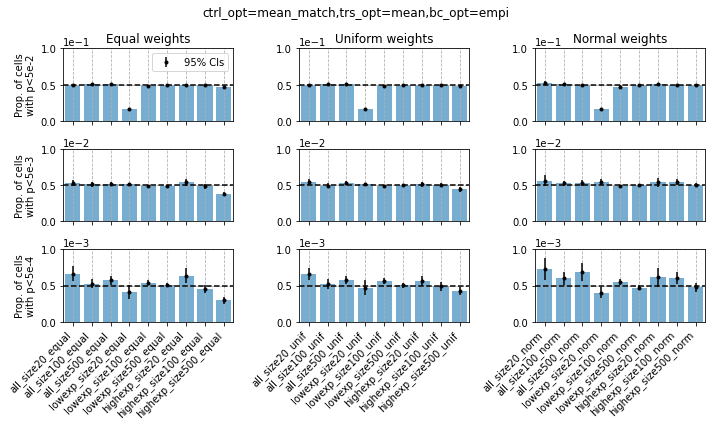

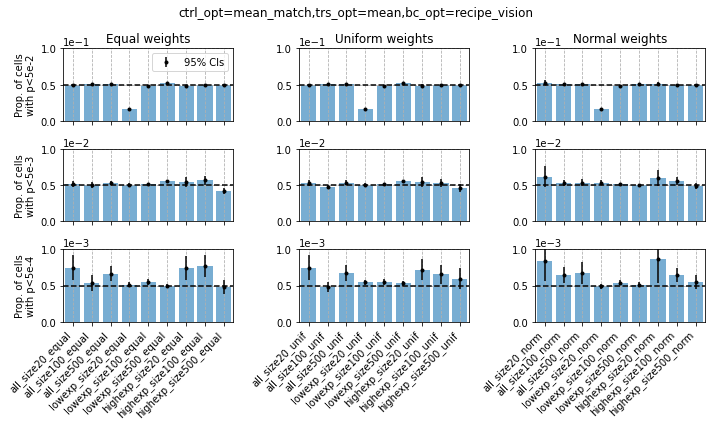

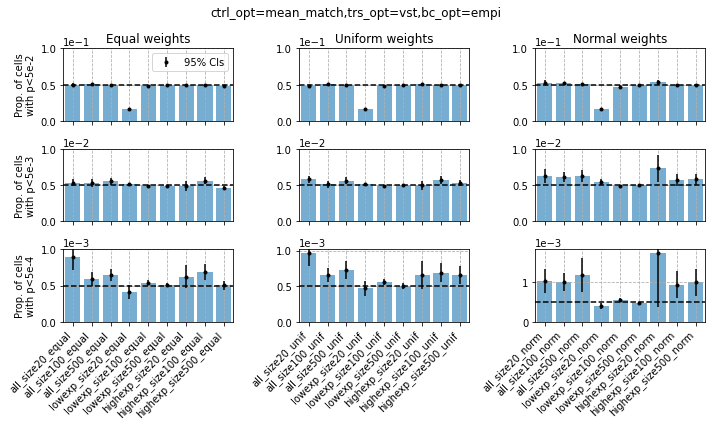

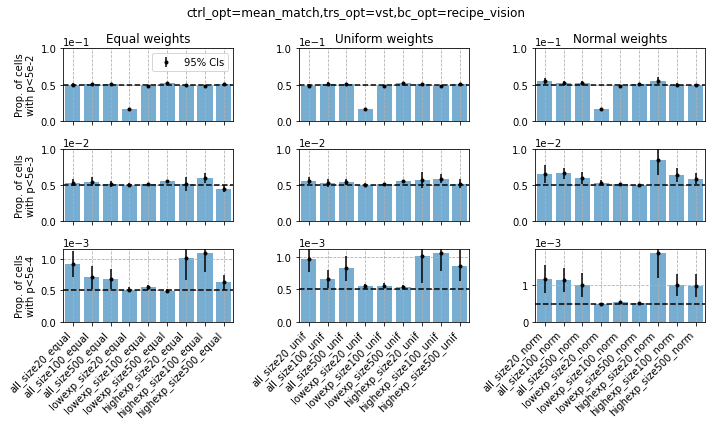

In [16]:
trait_list = ['all_size20', 'all_size100', 'all_size500',
              'lowexp_size20', 'lowexp_size100', 'lowexp_size500',
              'highexp_size20', 'highexp_size100', 'highexp_size500']
dic_weight_name = {'equal':'Equal weights', 'unif':'Uniform weights', 'norm':'Normal weights'}

# trait_list = ['%s_equal'%x for x in trait_list] + ['%s_unif'%x for x in trait_list] \
#                 + ['%s_norm'%x for x in trait_list]

md_list = ['ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision']

for mname in md_list:
    
    plt.figure(figsize=[10,6])
    
    for i_cutoff,cutoff in enumerate([2,3,4]):
        
        thres = 5*10**(-cutoff)
        
        for i_weight_opt,weight_opt in enumerate(['equal', 'unif', 'norm']):
            
            trait_w_list = ['%s_%s'%(x,weight_opt) for x in trait_list]
            plt.subplot(3,3,i_cutoff*3+i_weight_opt+1)
            plt.bar(range(len(trait_w_list)), df_plot.loc[mname, ['%s.mean.5en%d'%(x,cutoff) for x in trait_w_list]], 
                    alpha=0.6)
            plt.errorbar(range(len(trait_w_list)), df_plot.loc[mname, ['%s.mean.5en%d'%(x,cutoff) for x in trait_w_list]],
                         yerr=1.96*df_plot.loc[mname, ['%s.se.5en%d'%(x,cutoff) for x in trait_w_list]],
                         color='k', fmt='.', label='95% CIs')    
            plt.plot([-0.5, len(trait_w_list)-0.5],[thres, thres], linestyle='--', color='k')
            plt.xlim([-0.5, len(trait_w_list)-0.5])
            max_val = 1.05*df_plot.loc[mname, ['%s.mean.5en%d'%(x,cutoff) for x in trait_w_list]].max()
            plt.ylim([0, max(max_val, 2*thres)] )
            plt.xticks(range(len(trait_w_list)), ['']*len(trait_w_list))
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            plt.grid(linestyle='--')
            
            if (i_weight_opt==0)&(i_cutoff==0):
                plt.legend()
                
            if i_weight_opt==0:
                plt.ylabel('Prop. of cells\nwith p<5e-%d'%cutoff)
        
            if i_cutoff==0:
                plt.title(dic_weight_name[weight_opt])                
            
            if i_cutoff==2:
                plt.xticks(range(len(trait_w_list)), trait_w_list, rotation='45', ha='right')
    
    plt.suptitle(mname)
    plt.tight_layout()
    plt.show()